## Importing required libraries

In [ ]:
# Importing libraries
import re
import shap
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import tensorflow as tf


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

os.environ["PYTONHASHSEED"] = '0'

In [2]:
# Defining a function to set seed
def set_seed(seed):

    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    return

## Importing data

In [ ]:
# Importing data from csv
df = pd.read_csv("Data/mudah-apartment-kl-selangor.csv")

## Exploratory data analysis

### Data types

In [ ]:
# Viewing the first 5 rows of the dataset
df.head()

,ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
0,100323185,The Hipster @ Taman Desa,2022.0,RM 4 200 per month,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842 sq.ft.,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...","Air-Cond, Cooking Allowed, Washing Machine",Kuala Lumpur
1,100203973,Segar Courts,NaN,RM 2 300 per month,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170 sq.ft.,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...","Air-Cond, Cooking Allowed, Near KTM/LRT",Kuala Lumpur
2,100323128,Pangsapuri Teratak Muhibbah 2,NaN,RM 1 000 per month,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650 sq.ft.,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",NaN,Kuala Lumpur
3,100191767,Sentul Point Suite Apartment,2020.0,RM 1 700 per month,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743 sq.ft.,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...","Cooking Allowed, Near KTM/LRT, Washing Machine",Kuala Lumpur
4,97022692,Arte Mont Kiara,NaN,RM 1 299 per month,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494 sq.ft.,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",Air-Cond,Kuala Lumpur


In [ ]:
# Checking the data types for each column
df.dtypes

ads_id                     int64
prop_name                 object
completion_year          float64
monthly_rent              object
location                  object
property_type             object
rooms                     object
parking                  float64
bathroom                 float64
size                      object
furnished                 object
facilities                object
additional_facilities     object
region                    object
dtype: object

Columns like "monthly_rent", "rooms", and "size" should be numerical but appears to be categorical.

In [ ]:
# Viewing the first 5 rows of "monthly_rent" column
df["monthly_rent"].head()

0    RM 4 200 per month
1    RM 2 300 per month
2    RM 1 000 per month
3    RM 1 700 per month
4    RM 1 299 per month
Name: monthly_rent, dtype: object

In [ ]:
# Extracting the numbers from "monthly_rent" column
df["monthly_rent"] = df["monthly_rent"].str.extractall(r"(\d+)").astype(str).groupby(level=0).agg("".join).astype(int)

df["monthly_rent"].head()

0    4200.0
1    2300.0
2    1000.0
3    1700.0
4    1299.0
Name: monthly_rent, dtype: float64

In [ ]:
# Viewing the unique values of "rooms" column
df["rooms"].unique()

array(['5', '3', '2', '1', '4', '7', '6', 'More than 10', nan, '9', '3.0',
       '4.0', '2.0', '1.0', '5.0', '9.0', '6.0', '7.0', '10.0'],
      dtype=object)

In [ ]:
# Replacing "More than 10" category with 11
df["rooms"].replace({"More than 10": 11}, inplace=True)

In [ ]:
#Converting the data type of "rooms" column to float
df["rooms"] = df["rooms"].astype(float)

df["rooms"].unique()

array([ 5.,  3.,  2.,  1.,  4.,  7.,  6., 11., nan,  9., 10.])

In [ ]:
# Viewing the first 5 row of the "size" column
df['size'].head()

0    1842 sq.ft.
1    1170 sq.ft.
2     650 sq.ft.
3     743 sq.ft.
4     494 sq.ft.
Name: size, dtype: object

In [ ]:
# Extracting the numbers from "size" column
df["size"] = df["size"].str.extractall(r"(\d+)").astype(str).groupby(level=0).agg("".join).astype(int)

df["size"].head()

0    1842
1    1170
2     650
3     743
4     494
Name: size, dtype: int32

In [ ]:
# Renaming the columns to include their units
df.rename(columns={'monthly_rent':'monthly_rent_rm', 'size':'size_sqft'}, inplace=True)

### Numerical columns

In [ ]:
# Defining the numerical columns
num_cols = ["monthly_rent_rm", "rooms", "parking", "bathroom", "size_sqft"]

In [ ]:
# Viewing summary of the numerical columns
df[num_cols].describe()

,monthly_rent_rm,rooms,parking,bathroom,size_sqft
count,1.998900e+04,19985.000000,14289.000000,19985.000000,1.999100e+04
mean,2.269084e+03,2.681111,1.416824,1.891719,5.922172e+03
std,2.241285e+04,0.812074,0.567368,0.556266,7.072596e+05
min,7.000000e+01,1.000000,1.000000,1.000000,1.000000e+00
25%,1.100000e+03,2.000000,1.000000,2.000000,7.500000e+02
50%,1.400000e+03,3.000000,1.000000,2.000000,8.860000e+02
75%,1.800000e+03,3.000000,2.000000,2.000000,1.044000e+03
max,2.400000e+06,11.000000,10.000000,8.000000,1.000000e+08


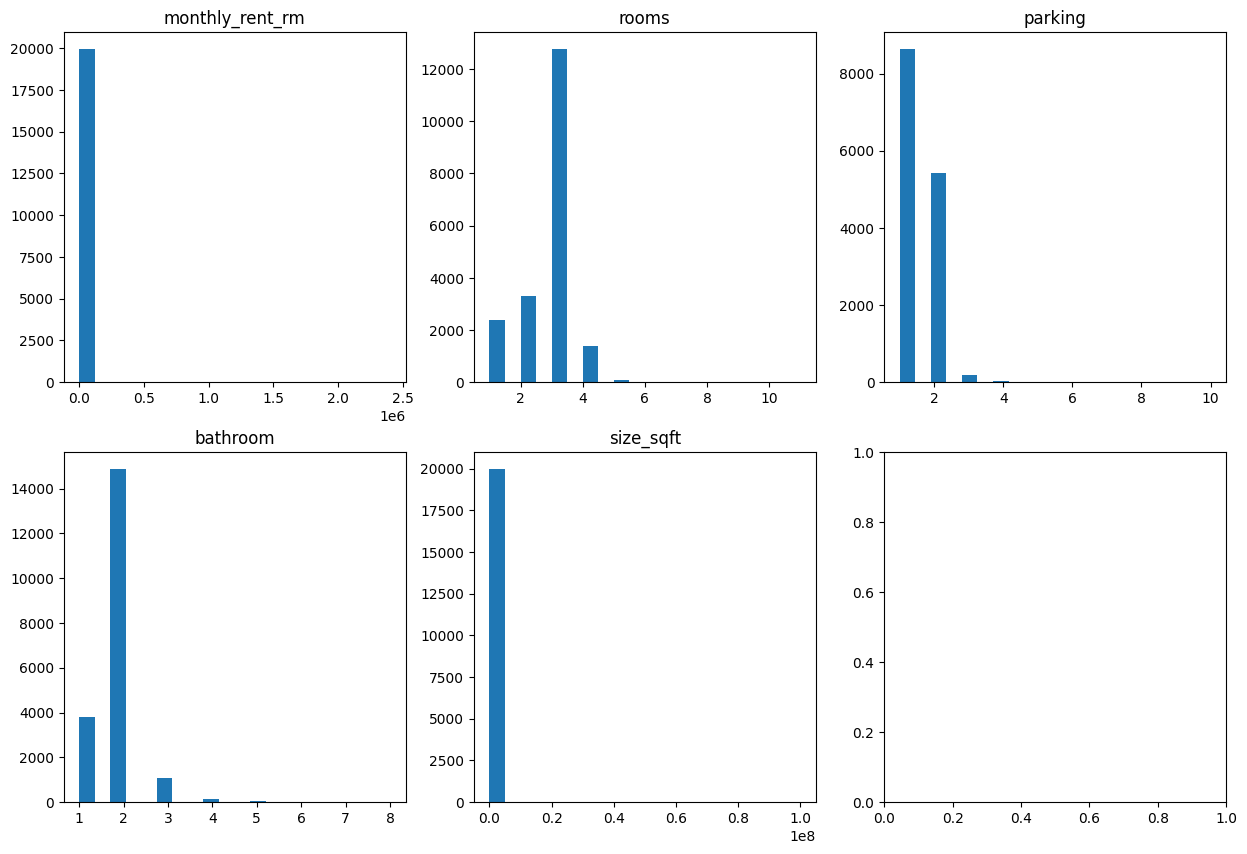

In [ ]:
# Plotting the histogram of the numerical columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    ax[i].hist(df[col], bins=20)
    ax[i].set_title(col)

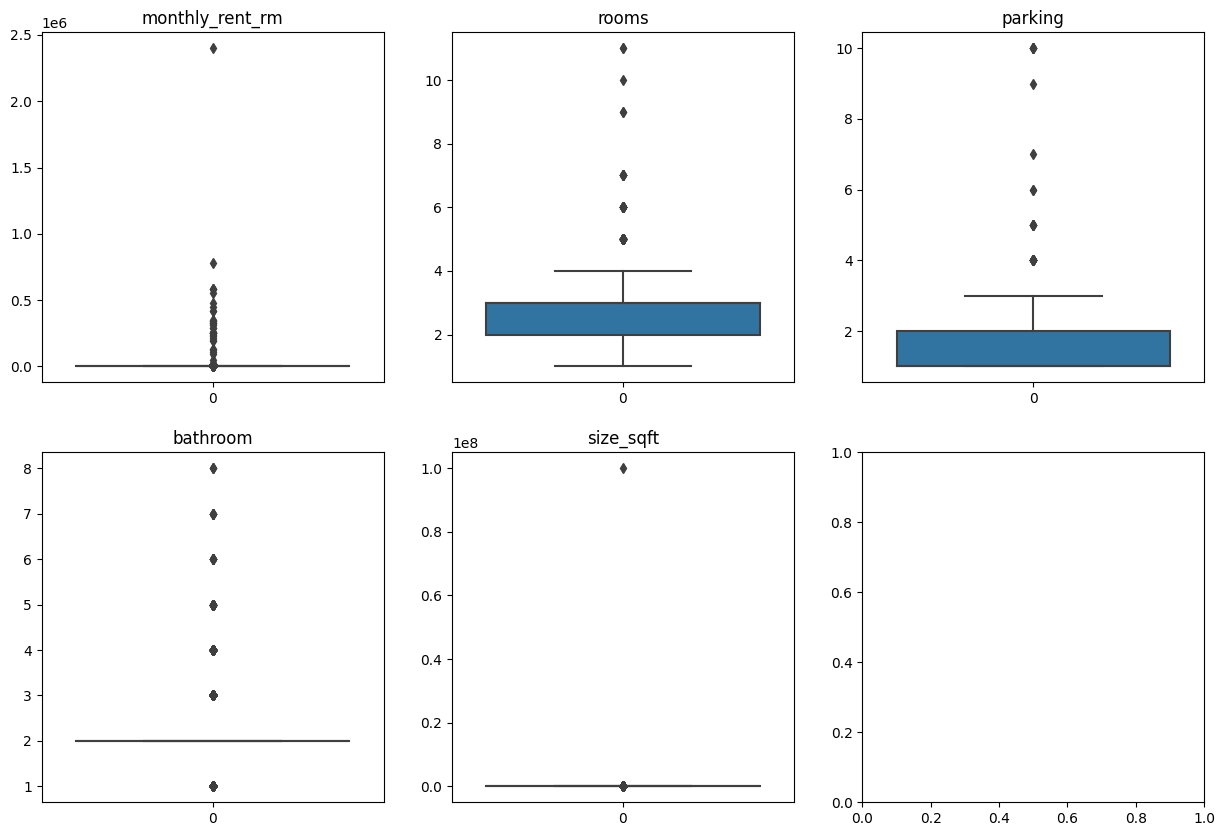

In [ ]:
# Plotting the boxplot of the numerical columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(df[col], ax=ax[i])
    ax[i].set_title(col)

According to the histogram and boxplot, the columns "monthly_rent_rm" and "size_sqft" have extreme outliers.

### Categorical columns

In [ ]:
# Defining the categorical columns
cat_col = ["completion_year", "location", "property_type", "furnished", "region", "facilities", "additional_facilities"]

In [ ]:
# Viewing the summary of the categorical columns
df[cat_col].describe(include="all")

,completion_year,location,property_type,furnished,region,facilities,additional_facilities
count,10806.000000,19991,19991,19986,19991,17782,14043
unique,NaN,134,13,3,2,10785,176
top,NaN,Kuala Lumpur - Cheras,Condominium,Fully Furnished,Selangor,"Parking, Security, Lift, Swimming Pool, Playgr...","Air-Cond, Cooking Allowed, Washing Machine"
freq,NaN,1623,8448,8462,10000,872,1927
mean,2014.822321,NaN,NaN,NaN,NaN,NaN,NaN
std,6.735355,NaN,NaN,NaN,NaN,NaN,NaN
min,1977.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,2012.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,2017.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2020.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Viewing the unique values of the categorical columns
for col in cat_col:
    print(col)
    print(df[col].unique())
    print()

completion_year
[2022.   nan 2020. 2018. 2014. 2019. 2017. 2021. 2006. 2015. 1999. 2004.
 2007. 2002. 1985. 2010. 2012. 1988. 1998. 2023. 1990. 2016. 2003. 2000.
 2008. 1995. 2013. 2011. 1994. 2009. 1996. 2005. 1993. 1997. 2001. 2025.
 1980. 1989. 1987. 1984. 2024. 1991. 1977.]

location
['Kuala Lumpur - Taman Desa' 'Kuala Lumpur - Cheras'
 'Kuala Lumpur - Sentul' 'Kuala Lumpur - Mont Kiara'
 'Kuala Lumpur - Setapak' 'Kuala Lumpur - Ampang'
 'Kuala Lumpur - Segambut' 'Kuala Lumpur - Desa ParkCity'
 'Kuala Lumpur - Bukit Jalil' 'Kuala Lumpur - Kepong'
 'Kuala Lumpur - KL City' 'Kuala Lumpur - Wangsa Maju'
 'Kuala Lumpur - Solaris Dutamas' 'Kuala Lumpur - Jalan Kuching'
 'Kuala Lumpur - Bandar Menjalara' 'Kuala Lumpur - Desa Pandan'
 'Kuala Lumpur - Old Klang Road' 'Kuala Lumpur - KLCC'
 'Kuala Lumpur - Ampang Hilir' 'Kuala Lumpur - Bukit Bintang'
 'Kuala Lumpur - Jalan Ipoh' 'Kuala Lumpur - Setiawangsa'
 'Kuala Lumpur - Gombak' 'Kuala Lumpur - Pantai'
 'Kuala Lumpur - Sungai Besi' 'Kual

"location" column need to be pre-processed to remove the first part of the string. While "facilities" and "additional_facilities" column can be expanded to multiple binary columns where the value is dependent upon the availability of the facility.

### Missing data analysis

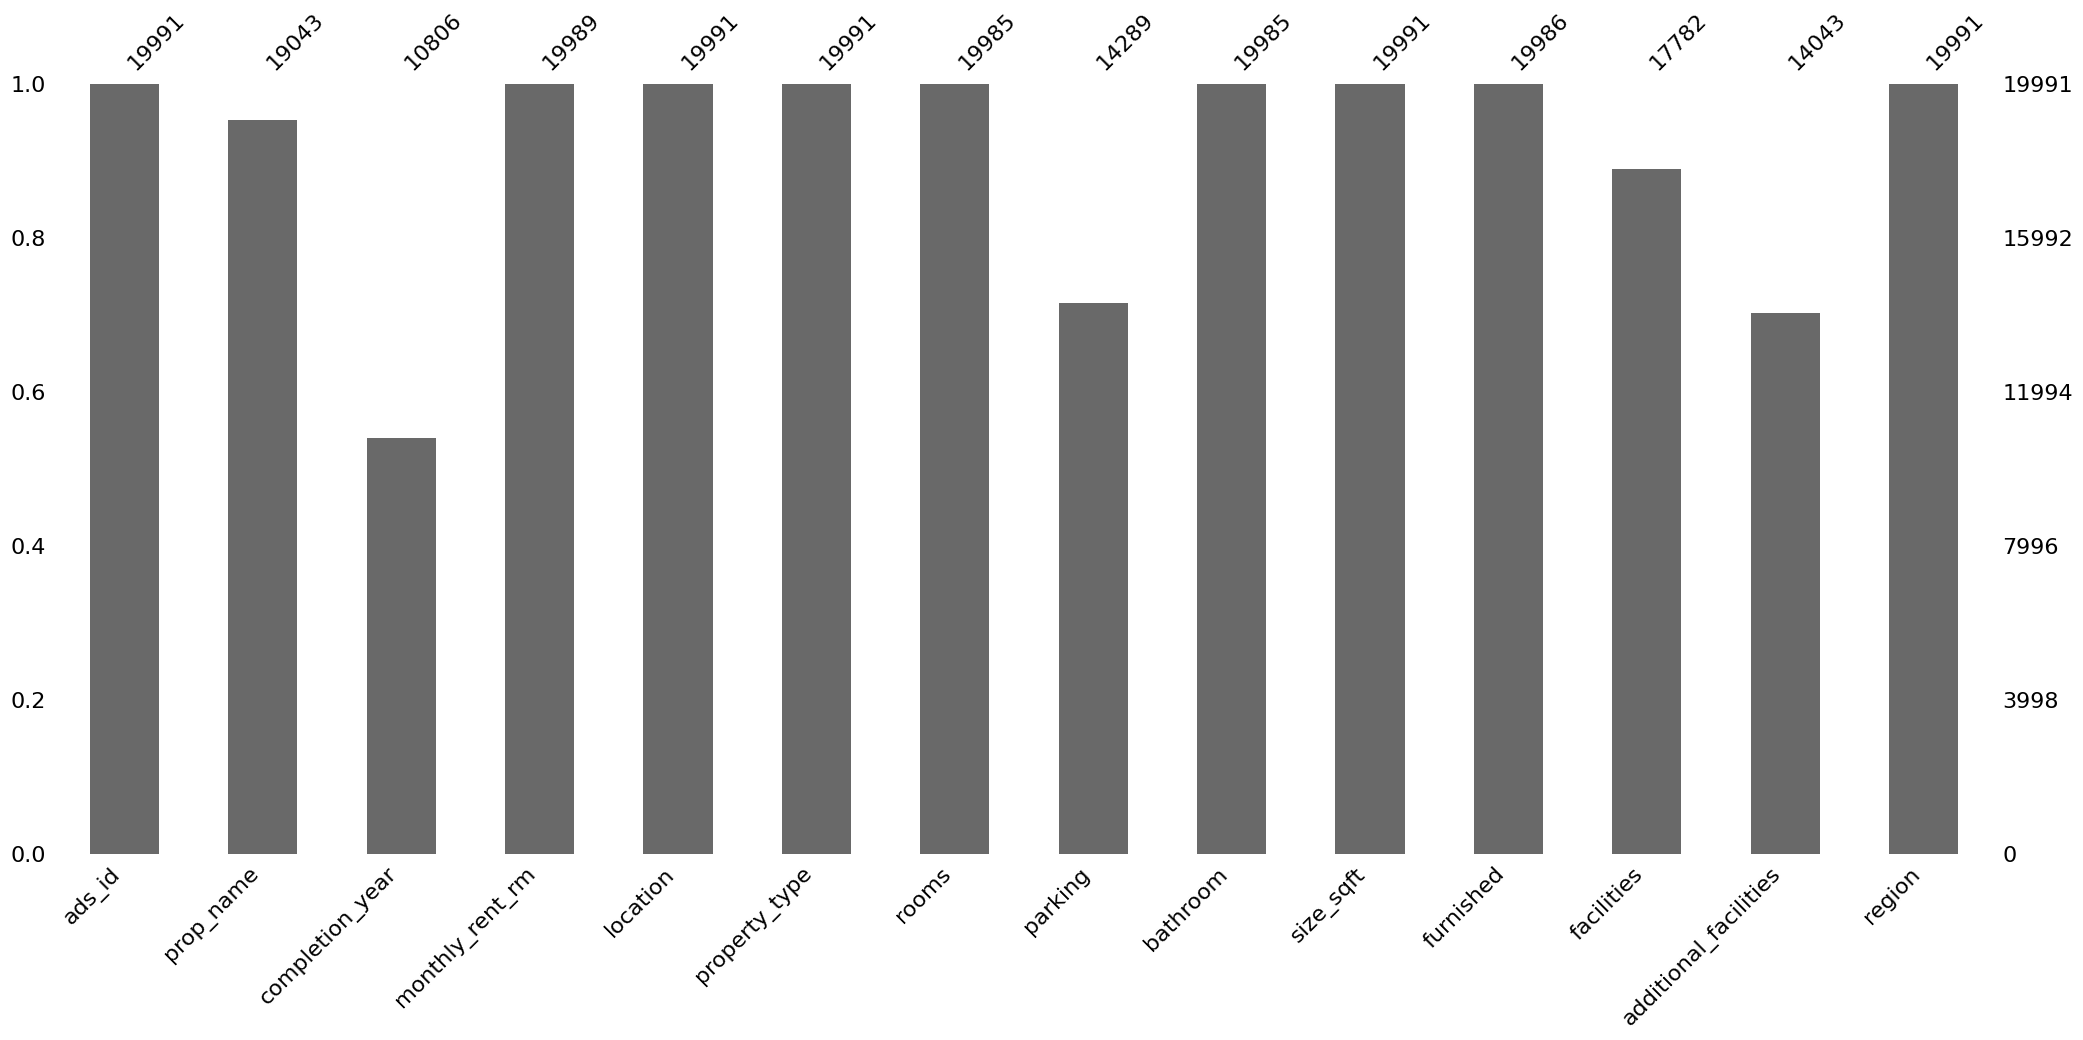

In [ ]:
# Plotting bar plot for missing data
msno.bar(df)
plt.show()

"prop_name", "completion_year", "monthly_rent_rm", "rooms", "parking", "bathroom", "furnished", "facilities" and "additional_facilities" have missing values.

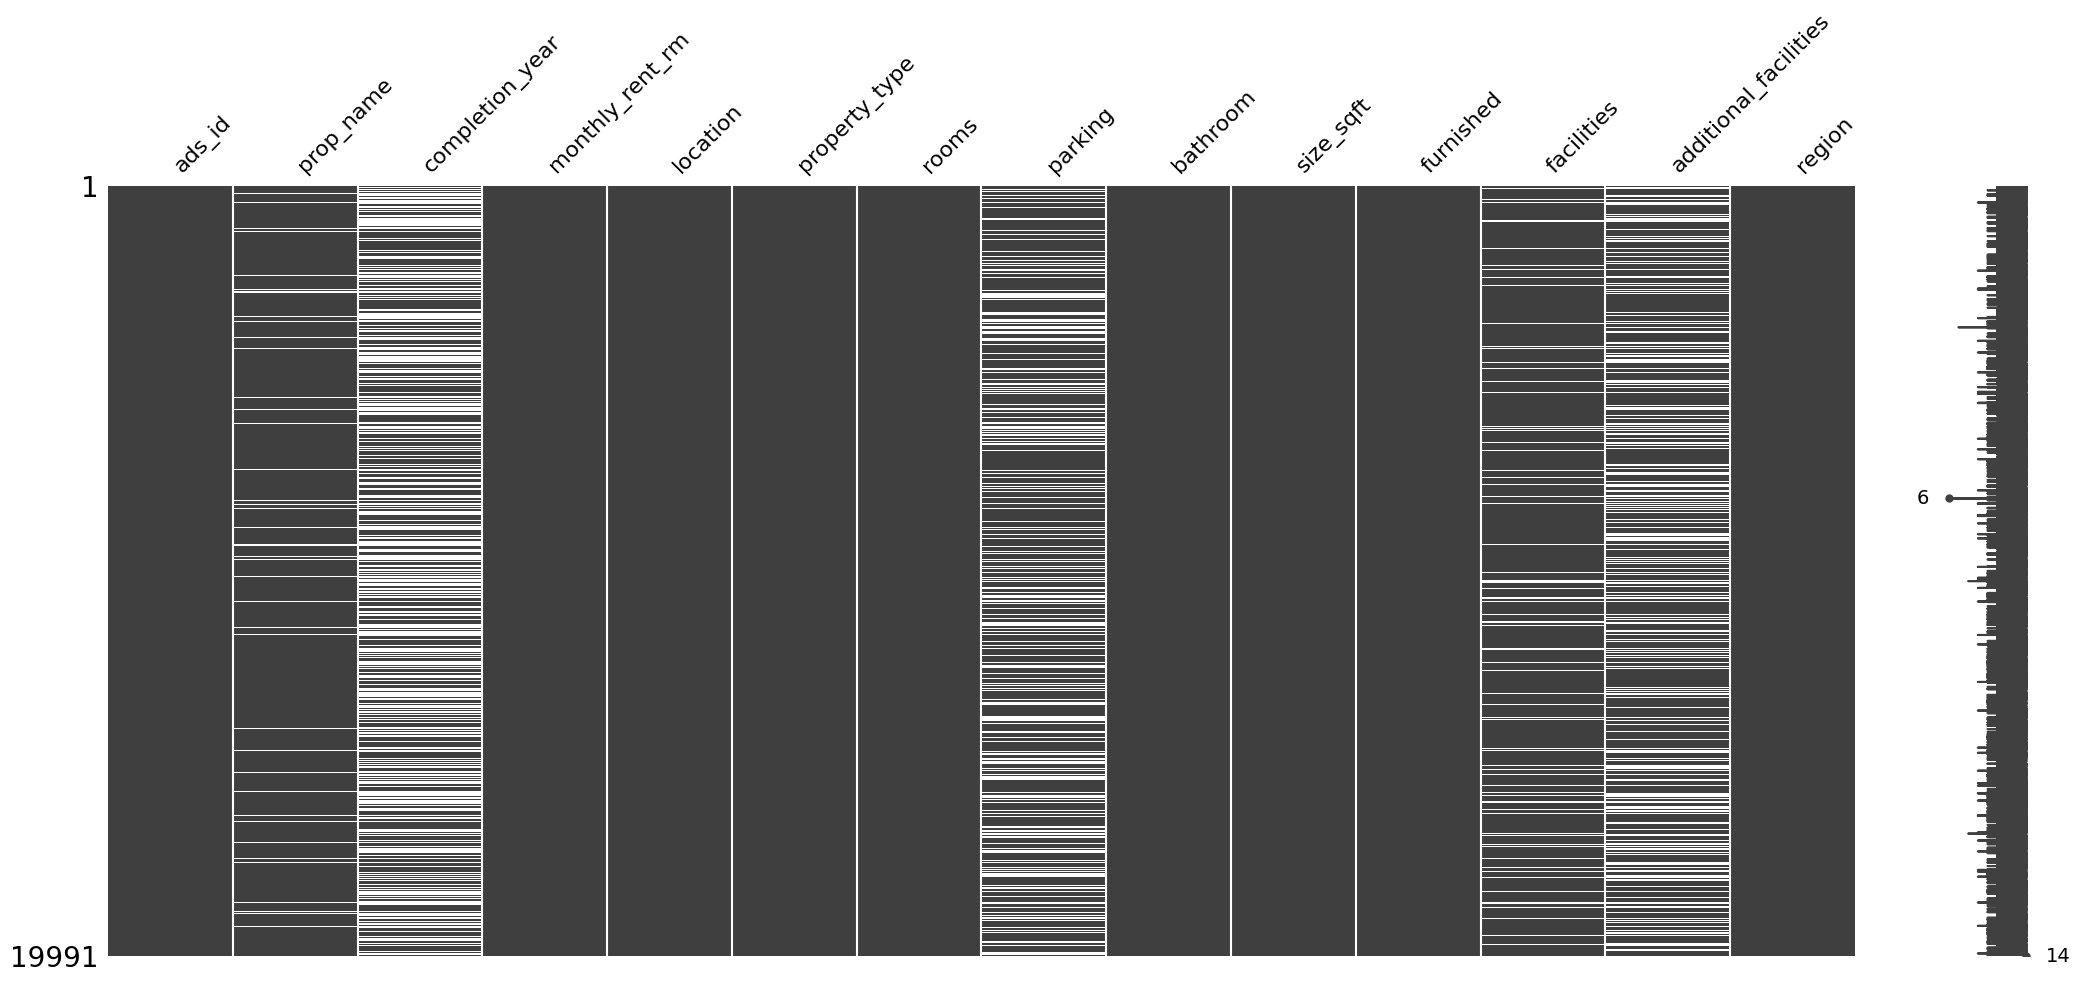

In [ ]:
# Plotting matrix for missing data
msno.matrix(df)
plt.show()

Upon visual inspection, there's no pattern between the missing values in the columns. We can speculate that missing values in all the columns are missing completely at random (MCAR).

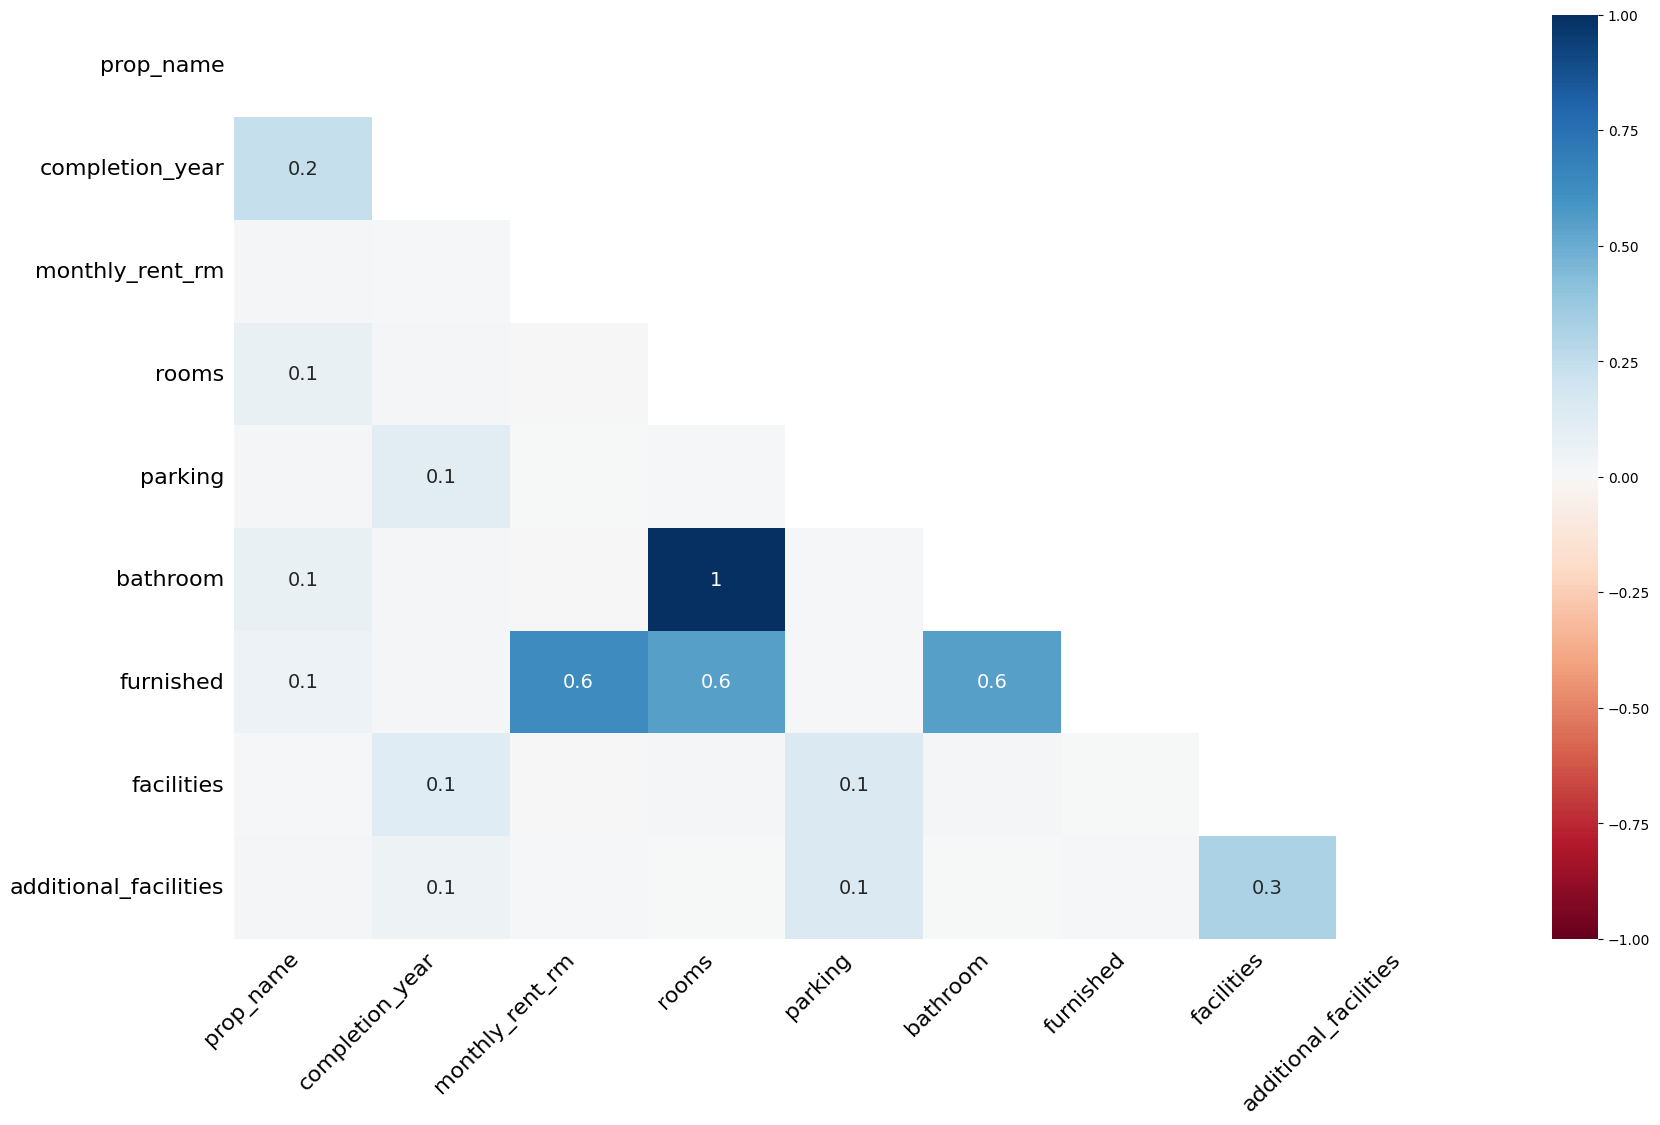

In [ ]:
# Plotting heatmap for correlations between missing values in columns
msno.heatmap(df)
plt.show()

Looking at the heatmap, it seems that only missing pattern in "furnished" is moderately correlated with "monthly_rent", "rooms" and "bathroom". Hence, we can assume that the missing values in these columns are missing at random (MAR).

## Data pre-processing

### Dropping duplicates

In [ ]:
# Dropping any duplicates
df.drop_duplicates(inplace=True)

df.head()

,ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region
0,100323185,The Hipster @ Taman Desa,2022.0,4200.0,Kuala Lumpur - Taman Desa,Condominium,5.0,2.0,6.0,1842,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...","Air-Cond, Cooking Allowed, Washing Machine",Kuala Lumpur
1,100203973,Segar Courts,NaN,2300.0,Kuala Lumpur - Cheras,Condominium,3.0,1.0,2.0,1170,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...","Air-Cond, Cooking Allowed, Near KTM/LRT",Kuala Lumpur
2,100323128,Pangsapuri Teratak Muhibbah 2,NaN,1000.0,Kuala Lumpur - Taman Desa,Apartment,3.0,NaN,2.0,650,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",NaN,Kuala Lumpur
3,100191767,Sentul Point Suite Apartment,2020.0,1700.0,Kuala Lumpur - Sentul,Apartment,2.0,1.0,2.0,743,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...","Cooking Allowed, Near KTM/LRT, Washing Machine",Kuala Lumpur
4,97022692,Arte Mont Kiara,NaN,1299.0,Kuala Lumpur - Mont Kiara,Service Residence,1.0,1.0,1.0,494,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",Air-Cond,Kuala Lumpur


### Dropping columns

In [ ]:
# Dropping unused columns
df.drop(columns=["ads_id", "prop_name"], inplace=True)

df.head()

,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region
0,2022.0,4200.0,Kuala Lumpur - Taman Desa,Condominium,5.0,2.0,6.0,1842,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...","Air-Cond, Cooking Allowed, Washing Machine",Kuala Lumpur
1,NaN,2300.0,Kuala Lumpur - Cheras,Condominium,3.0,1.0,2.0,1170,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...","Air-Cond, Cooking Allowed, Near KTM/LRT",Kuala Lumpur
2,NaN,1000.0,Kuala Lumpur - Taman Desa,Apartment,3.0,NaN,2.0,650,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",NaN,Kuala Lumpur
3,2020.0,1700.0,Kuala Lumpur - Sentul,Apartment,2.0,1.0,2.0,743,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...","Cooking Allowed, Near KTM/LRT, Washing Machine",Kuala Lumpur
4,NaN,1299.0,Kuala Lumpur - Mont Kiara,Service Residence,1.0,1.0,1.0,494,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",Air-Cond,Kuala Lumpur


### Clipping outliers

In [ ]:
# Removing outliers for "monthly_rent_rm" column
monthly_rent_pct = df["monthly_rent_rm"].quantile(0.99)
df["monthly_rent_rm"] = df["monthly_rent_rm"].clip(upper=monthly_rent_pct)

In [ ]:
# Removing outliers for "size_sqft" column
size_pct = df["size_sqft"].quantile(0.99)
df["size_sqft"] = df["size_sqft"].clip(upper=size_pct)

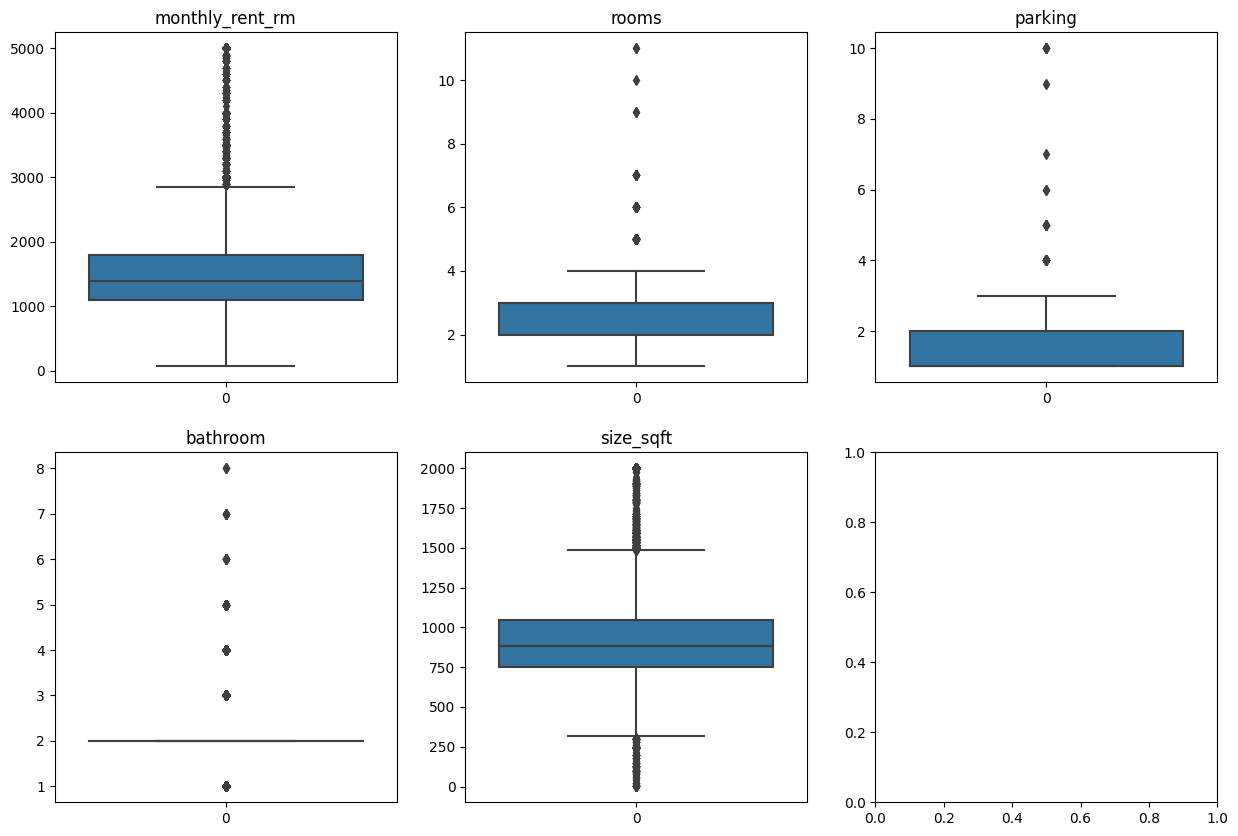

In [ ]:
# Plotting boxplot of the numerical columns after removing outliers
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(df[col], ax=ax[i])
    ax[i].set_title(col)

### Removing region from values in "location" column 

In [ ]:
# Removing the region from the location value
df["location"] = df["location"].apply(lambda x: re.split(r"( - *)", x)[-1])

#Viewing results of the location column
df["location"].head()

0    Taman Desa
1        Cheras
2    Taman Desa
3        Sentul
4    Mont Kiara
Name: location, dtype: object

### Creating dummy variables based on "facilities" and "additional_facilities" columns

In [ ]:
# Defining a function to create dummy variables based on the values in the "facilities" and "additional_facilities" column
def create_columns(df, col_name):

    temp = df.copy()
    temp[col_name] = temp[col_name].apply(lambda x: re.sub(r"\d+", "", str(x)))
    temp[col_name] = temp[col_name].apply(lambda x: re.sub(r"\s+", "", str(x)))
    temp[col_name] = temp[col_name].str.split(",")

    new_cols = pd.get_dummies(temp[col_name].apply(pd.Series).stack()).groupby(level=0).sum().astype(int)

    return new_cols

In [ ]:
# Creating dummy variables for "facilities" column
create_columns(df, "facilities").head()

,,Barbequearea,Clubhouse,Gymnasium,JoggingTrack,Lift,Minimart,Multipurposehall,Parking,Playground,Sauna,Security,SquashCourt,SwimmingPool,TennisCourt,nan
0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0
1,0,1,0,1,1,1,0,0,1,1,1,1,0,1,0,0
2,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,1,1,0,1,1,0,1,1,1,0,0
4,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0


In [ ]:
# Adding the dummy variables of "facilities" to df
df = pd.concat([df, create_columns(df, "facilities").iloc[:, 1:-1]], axis=1)

In [ ]:
# Adding the dummy variables of "additional facilities" to df
df = pd.concat([df, create_columns(df, "additional_facilities").iloc[:, 1:-1]], axis=1)

### One-hot encoding "property_type", "furnished" and "region" column

In [ ]:
# One-hot encoding the "property_type" column
ohe_property_type = pd.get_dummies(df['property_type'], prefix='PropertyType').astype(int) #drop_first=True
ohe_property_type

,PropertyType_Apartment,PropertyType_Bungalow House,PropertyType_Condo / Services residence / Penthouse / Townhouse,PropertyType_Condominium,PropertyType_Duplex,PropertyType_Flat,PropertyType_Houses,PropertyType_Others,PropertyType_Residential,PropertyType_Service Residence,PropertyType_Soho,PropertyType_Studio,PropertyType_Townhouse Condo
0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19986,1,0,0,0,0,0,0,0,0,0,0,0,0
19987,0,0,0,0,0,0,0,0,0,1,0,0,0
19988,0,0,0,1,0,0,0,0,0,0,0,0,0
19989,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# One-hot encoding the "furnished" column
ohe_furnished = pd.get_dummies(df["furnished"]).astype(int)

ohe_furnished

,Fully Furnished,Not Furnished,Partially Furnished
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
...,...,...,...
19986,0,0,1
19987,0,0,1
19988,0,0,1
19989,1,0,0


In [ ]:
# One-hot encoding the "region" column
ohe_region = pd.get_dummies(df['region'], prefix='Region').astype(int)

ohe_region

,Region_Kuala Lumpur,Region_Selangor
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
19986,0,1
19987,0,1
19988,0,1
19989,0,1


In [ ]:
# Concatenating the one-hot encoded columns to df
df = pd.concat([df, ohe_property_type, ohe_furnished, ohe_region], axis=1)

### Principal component analysis of "location" column

In [ ]:
# One-hot encoding for "location" variable
ohe_location = pd.get_dummies(df["location"], prefix="Location", drop_first=True)

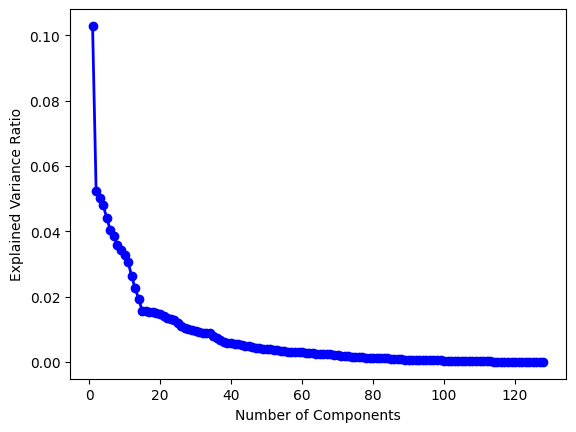

In [ ]:
from sklearn.decomposition import PCA

# instantiate a PCA object with the desired number of components
pca = PCA()

# fit the PCA object to the data
pca.fit(ohe_location)

# plot the explained variance ratio for each principal component
plt.plot(range(1, ohe_location.shape[1]+1), pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
# Transform the data using the fitted PCA object
transformed_loc = pd.DataFrame(pca.transform(ohe_location)).iloc[:, :14]

In [ ]:
# Adding prefix to the column names
transformed_loc = transformed_loc.add_prefix("loc_")

In [ ]:
# Resetting the index
df.reset_index(drop=True, inplace=True)

In [ ]:
# Concatenating the transformed location columns to df
df = pd.concat([df, transformed_loc], axis=1)

df.head()

,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,...,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13
0,2022.0,4200.0,Taman Desa,Condominium,5.0,2.0,6.0,1842.0,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...",...,-0.041429,-0.000731,0.040977,-0.029348,0.008575,0.038371,0.033188,0.132566,-0.145651,-0.151728
1,NaN,2300.0,Cheras,Condominium,3.0,1.0,2.0,1170.0,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...",...,0.017588,0.000257,-0.012976,0.007970,-0.002116,-0.008392,-0.006300,-0.017027,0.011831,0.006579
2,NaN,1000.0,Taman Desa,Apartment,3.0,NaN,2.0,650.0,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",...,-0.041429,-0.000731,0.040977,-0.029348,0.008575,0.038371,0.033188,0.132566,-0.145651,-0.151728
3,2020.0,1700.0,Sentul,Apartment,2.0,1.0,2.0,743.0,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...",...,-0.325387,0.711218,-0.503611,0.134743,-0.027330,-0.085402,-0.052663,-0.103166,0.059160,0.028855
4,NaN,1299.0,Mont Kiara,Service Residence,1.0,1.0,1.0,494.0,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",...,-0.041504,-0.000733,0.041069,-0.029422,0.008598,0.038487,0.033300,0.133195,-0.146700,-0.153715


### Imputing missing values

In [ ]:
# Checking for msising values
df.isna().sum()

completion_year    9181
monthly_rent_rm       2
location              0
property_type         0
rooms                 6
                   ... 
loc_9                 0
loc_10                0
loc_11                0
loc_12                0
loc_13                0
Length: 63, dtype: int64

In [ ]:
# Dropping rows with missing values in "monthly_rent_rm", "rooms", "bathroom" and "furnished" columns
df.dropna(subset=["monthly_rent_rm", "rooms", "bathroom", "furnished"], inplace=True)

In [ ]:
# Fill missing values in "parking" column with the mode
df["parking"].fillna(df["parking"].mode().iloc[0], inplace=True)

In [ ]:
# Checking missing values after missing value treatment
df.isna().sum()

completion_year    9173
monthly_rent_rm       0
location              0
property_type         0
rooms                 0
                   ... 
loc_9                 0
loc_10                0
loc_11                0
loc_12                0
loc_13                0
Length: 63, dtype: int64

### Train-test split

In [ ]:
df.columns

Index(['completion_year', 'monthly_rent_rm', 'location', 'property_type',
       'rooms', 'parking', 'bathroom', 'size_sqft', 'furnished', 'facilities',
       'additional_facilities', 'region', 'Barbequearea', 'Clubhouse',
       'Gymnasium', 'JoggingTrack', 'Lift', 'Minimart', 'Multipurposehall',
       'Parking', 'Playground', 'Sauna', 'Security', 'SquashCourt',
       'SwimmingPool', 'TennisCourt', 'Air-Cond', 'CookingAllowed', 'Internet',
       'NearKTM/LRT', 'WashingMachine', 'PropertyType_Apartment',
       'PropertyType_Bungalow House',
       'PropertyType_Condo / Services residence / Penthouse / Townhouse',
       'PropertyType_Condominium', 'PropertyType_Duplex', 'PropertyType_Flat',
       'PropertyType_Houses', 'PropertyType_Others',
       'PropertyType_Residential', 'PropertyType_Service Residence',
       'PropertyType_Soho', 'PropertyType_Studio',
       'PropertyType_Townhouse Condo', 'Fully Furnished', 'Not Furnished',
       'Partially Furnished', 'Region_Kuala Lum

In [ ]:
# Subsetting X and y
X = df.drop(columns=['completion_year', "location", "property_type", "furnished", "facilities", "additional_facilities", "region", "monthly_rent_rm"], axis=1)
y = df["monthly_rent_rm"]

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

### Scaling training data

In [ ]:
# Initializing the MinMaxScaler objects
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [ ]:
#Scaling training data
X_scaled = X_scaler.fit_transform(X_train)
y_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1,1))

## Modelling

In [ ]:
# Setting seed for kernel initializers
init = tf.keras.initializers.GlorotUniform(seed=7)

In [ ]:
# define the model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='relu', kernel_initializer=init))
# model.add(Dense(64, activation='relu', kernel_initializer=init))
# model.add(Dense(32, activation='relu', kernel_initializer=init))
model.add(Dense(1, activation='linear', kernel_initializer=init))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# setting the seed
set_seed(7)

# train the model
history = model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
350/350 [==============================] - 1s 894us/step - loss: 0.0250 - val_loss: 0.0133
Epoch 2/50
350/350 [==============================] - 0s 801us/step - loss: 0.0130 - val_loss: 0.0108
Epoch 3/50
350/350 [==============================] - 0s 831us/step - loss: 0.0114 - val_loss: 0.0100
Epoch 4/50
350/350 [==============================] - 0s 842us/step - loss: 0.0107 - val_loss: 0.0098
Epoch 5/50
350/350 [==============================] - 0s 803us/step - loss: 0.0102 - val_loss: 0.0091
Epoch 6/50
350/350 [==============================] - 0s 805us/step - loss: 0.0100 - val_loss: 0.0092
Epoch 7/50
350/350 [==============================] - 0s 864us/step - loss: 0.0098 - val_loss: 0.0086
Epoch 8/50
350/350 [==============================] - 0s 841us/step - loss: 0.0096 - val_loss: 0.0088
Epoch 9/50
350/350 [==============================] - 0s 830us/step - loss: 0.0096 - val_loss: 0.0087
Epoch 10/50
350/350 [==============================] - 0s 798us/step - loss: 0.009

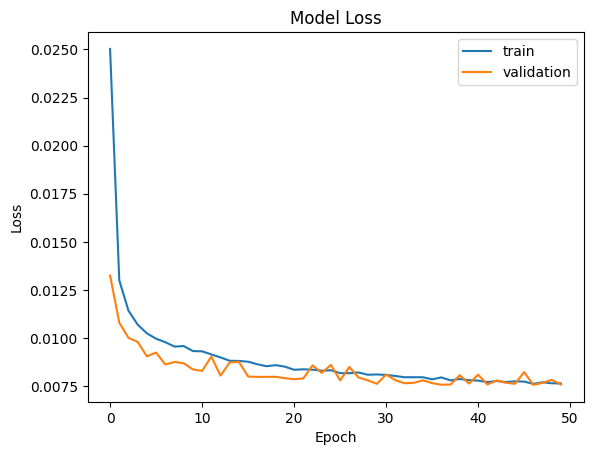

In [ ]:
# Plotting the train and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Scaling testing data
X_test_sc = X_scaler.transform(X_test)

In [ ]:
# Prediction using the trained model
y_hat = model.predict(X_test_sc)

188/188 [==============================] - 0s 538us/step


In [ ]:
# Inverse transforming the predicted y values
y_hat = y_scaler.inverse_transform(y_hat)

In [ ]:
# Defining a function to generate metrics
def evaluate(y_true, y_pred):

    print("R2 score: {:.3f}".format(r2_score(y_true, y_pred)))
    print("RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("MAE: {:.3f}".format(mean_absolute_error(y_true, y_pred)))

    return

In [ ]:
# Generating metrics
evaluate(y_test, y_hat)

R2 score: 0.657
RMSE: 463.743
MAE: 302.481


## SHAP Explainer

SHapley Additive exPlanations (SHAP) is a way to reverse-engineer the output of any predictive algorithm, as well as make it more transparent and interpretable (For the original paper, please visit https://arxiv.org/abs/1705.07874). It is based on cooperative game theory, whereby each possible combination of players should be considered to determine the importance of a single player. The main concept is that the impact of a feature doesn't rely only on one single feature, but on the entire set of features in the dataset. Imagine that we have a predictive model, then:

- The "game" is the prediction task.
- The "players" are the features.

It is important to stress that one "game" equates to one observation in the dataset.

### Model-Agnostic

In fact, the SHAP explainer is perfect for explaining the output of any machine learning model, as it is model-agnostic. It can be used for any type of model, including tree-based models, linear models, neural networks, etc. It can also be used for any type of data, including tabular data, text, images, etc. Although some predictive algorithms also provides indicators of the overall importance for each feature. For example:
- Linear models, uses their coefficients as feature importance
- Tree-based models, uses the impurity-based feature importance

However, these feature importances cannot account for local importance of the feature, and also how it changes with lower or higher values.

### Local vs global importances

SHAP explainer  can also disclose the individual contributions of each player on the output of the model, for each sample/observation. This is known as the local importance, while the mean absolute value of all local importances throughout the dataset is known as the global importance. 

### SHAP values

#### Power Set

SHAP values are based on the idea that the outcome of each possible combination (or coalition) of players should be considered to determine the importance of a single player. Hence, each possible combination of features can be represented as a tree, as shown in the figure below. 

![shap](Images\1_GOwxZ1ApAidTIDoa2l98ew.webp)

In the figure above, each node represents a combination of features, while each edge represents the inclusion of a feature not present in the previous combinations. SHAP will train a distinct predictive model over all combination of features, whereby these models will be completely equivalent to each other with regards to the hyperparameters and training data. The only difference between the models are the set of features included in the model.

#### Marginal Contributions

![shap1](Images\1_9oHGJ9kAMaUUEYtnfKKKEA.webp)

Let's imagine that for each combination of features, a model is trained and used to do some prediction using the same input. Hence, each node in the figure above represents a model and the prediction for each model can be seen in the figure. As seen in the figure above, two nodes connected by an edge differ by just one feature. Hence, the difference between the predictions of two connected nodes could be attributed to the effect of the additional feature. This is known as "<b>marginal contribution</b>" of a feature. Therefore, each edge represents the marginal contribution of a feature.

The marginal contribution of a feature can be quantified as such:

$MC_{age,\{age\}}(x_0) = Predict_{\{age\}}(x_0) - Predict_{\emptyset}(x_0)
                     = 40k - 50k 
                     = -10k $

Another example:

$MC_{gender,\{gender\}}(x_0) = Predict_{\{gender\}}(x_0) - Predict_{\emptyset}(x_0)
                     = 48k - 50k 
                     = -2k $

![shap1](Images\1_7keBLSQszepu5jITz8SKxA.webp)

In order to obtain the overall effect of a feature on the final mode, it is necessary to consider the marginal contributions of the feature in all the models where the feature is present. We need to consider all edges connecting nodes where:

- The upper node does not contain the feature
- And the bottom node contains the feature

In the figure, you can see an example of all the marginal contributions of the age feature.

#### Weighted Averaging

All the marginal contributions are aggregated through a weighted average to obtain the overall effect of the feature.

$SHAP_{age}(x_0) = w_{1} \times MC_{age,\{age\}}(x_0) +$
                  $w_{2} \times MC_{age,\left\{Age,Gender\right\}}(x_0) +$
                  $w_{3} \times MC_{age,\left\{Age,Job\right\}}(x_0) +$
                  $w_{4} \times MC_{age,\left\{Age,Gender,Job\right\}}(x_0)$

The weights of the edges are determined by the following ideas:
- Sum of the weights of all the marginal contributions to 1-feature models should be equal to the sum of the weighs of all the marginal contributions to 2-feature-models and so on. ($w_{1} = w_{2} + w_{3} = w_{4}$)
- All the weights of the marginal contributions to n-feature models should be equal to each other, for each n. ($w_{2} = w_{3}$)
- All the weights should sum to 1 ($w_{1} + w_{2} + w_{3} + w_{4} = 1$)

Is there an easier way to calculate the weights of the marginal contributions/edges?

Yes there is! Using a mathematical formula.
1) The weight of a marginal contribution to a n-feature-model is the <b>reciprocal</b> of the number of possible marginal contributions to all the n-feature models.
2) Each n-feature-model has n marginal contributions, so it is enough to count the number of possible n-feature-models and to multiply it by n.
3) To know the number of possible n-feature-models, given n and knowing that the total number of features is F, we can use binomial coefficient.

Hence, the weight of a marginal contribution to a n-feature-model is:

$[n \times \binom{F}{n}]^{-1}$

If we use <b>age</b> as an example, we get the following calculation:

$SHAP_{age}(x_0) = [1 \times \binom{3}{1}]^{-1} \times MC_{age,\{age\}}(x_0) +$
                  $[2 \times \binom{3}{2}]^{-1} \times MC_{age,\left\{Age,Gender\right\}}(x_0) +$
                  $[2 \times \binom{3}{2}]^{-1} \times MC_{age,\left\{Age,Job\right\}}(x_0) +$
                  $[3 \times \binom{3}{3}]^{-1} \times MC_{age,\left\{Age,Gender,Job\right\}}(x_0)\\$
                  $\qquad \qquad \qquad = \frac{1}{3} \times (-10k) + \frac{1}{6} \times (-9k) + \frac{1}{6} \times (-15k) + \frac{1}{3} \times (-12k)\\$
                  $\qquad \qquad \qquad = -11.33k$

#### Formula

Hence, the formula for SHAP values of any feature is as follow:

$SHAP_{feature}(x) = \sum_{set:feature \subseteq set} [|set| \times\binom{F}{|set|}]^{-1} [Predict_{set}(x) - Predict_{set \setminus feature}(x)]$


SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.
SHAP values are calculated by considering all possible predictions and the impact that each feature has on each prediction. The SHAP values are then averaged across all predictions to determine the importance of each feature.

#### Implementation

In [ ]:
explainer = shap.Explainer(model=model, masker=X_scaled, feature_names=X_train.columns)

In [ ]:
shap_values = explainer(X_test_sc)

Permutation explainer: 5994it [07:40, 12.76it/s]                          


### SHAP plots

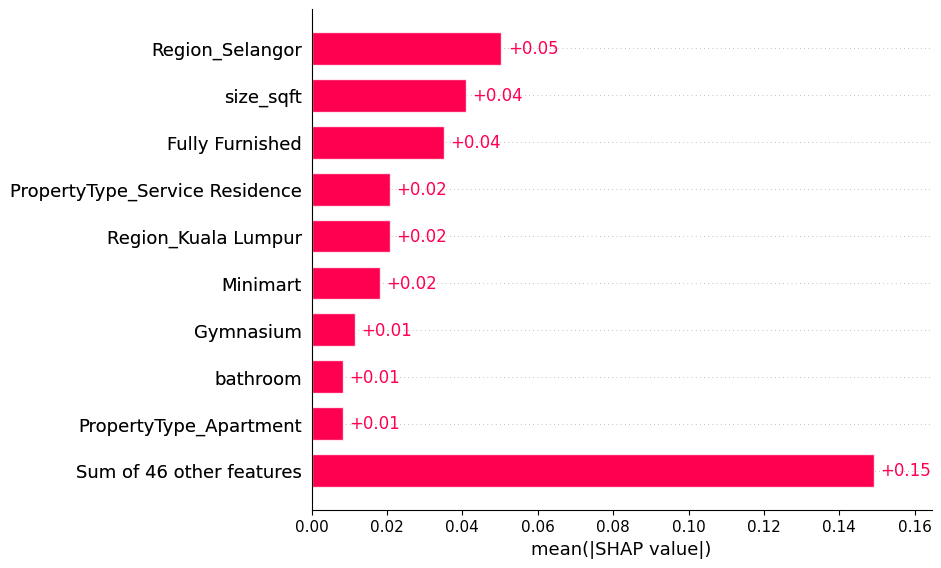

In [ ]:
shap.plots.bar(shap_values)

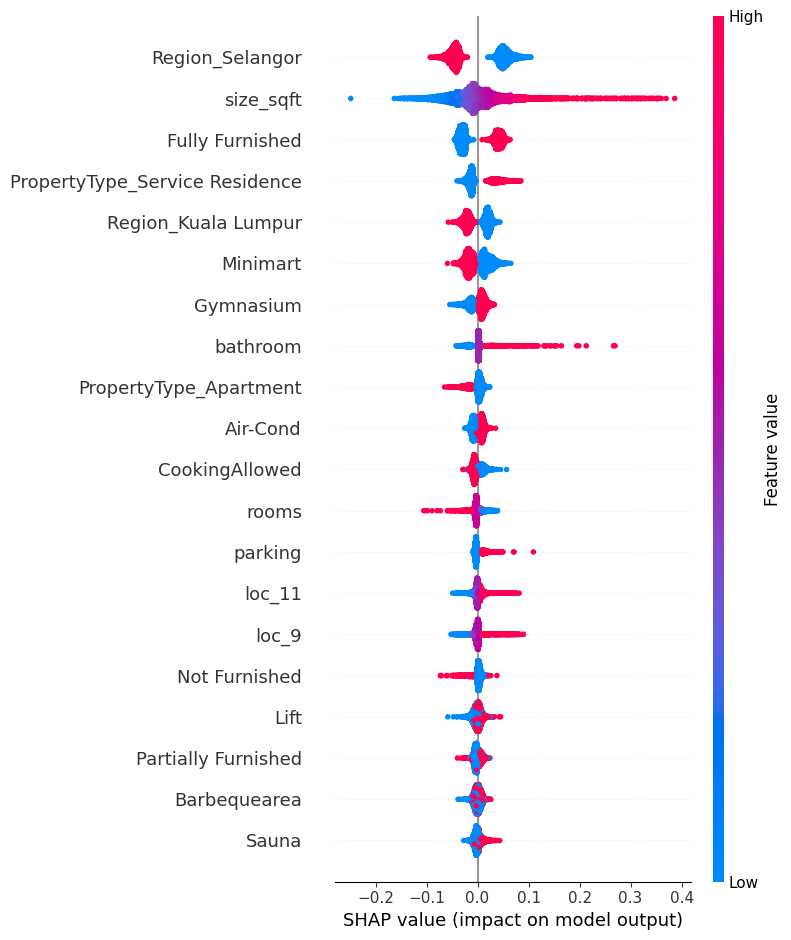

In [ ]:
shap.summary_plot(shap_values)

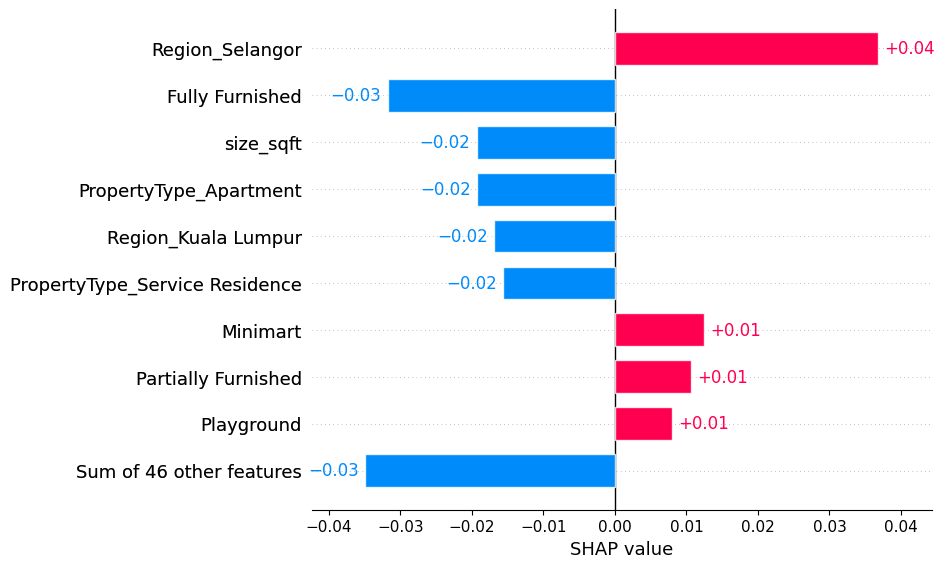

In [ ]:
shap.plots.bar(shap_values[0])

## References

https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

https://arxiv.org/abs/1705.07874